# ДЗ к уроку 6. Градиентный бустинг

## 1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):

    train_prediction = gb_predict(X_train, trees, coefs, eta)    
    train_mse = mean_squared_error(y_train, train_prediction)
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_mse = mean_squared_error(y_test, test_prediction)
    """     
    if trees_:
       
            message = f""
                При количестве деревьев = {trees}:
                на тренировочной выборке: {mean_squared_error(y_train, train_prediction)},
                на тестовой выборке: {mean_squared_error(y_test, test_prediction)}
        ""
        print(message)
        
    if depth_:
        message = f""
                'При максимальной глубине деревьев = {max_depth}:
                на тренировочной выборке: {mean_squared_error(y_train, train_prediction)},
                на тестовой выборке: {mean_squared_error(y_test, test_prediction)}

        print(message)
        """    
    return train_mse, test_mse

### *от количества деревьев в ансамбле*

In [10]:
%%time
max_depth = 3
eta = 0.1

n_trees_ = np.arange(1, 50, 3)

train_mse = []
test_mse = []

for n_trees in n_trees_:
    coefs = [1] * n_trees
    trees = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_mse.append(train_err)
    test_mse.append(test_err)

Wall time: 5min 52s


In [11]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [12]:
def error_of_n_trees_plot(n_trees, train_errors, test_errors):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_errors, label='train error')
    plt.plot(list(range(n_trees)), test_errors, label='test error')
    plt.legend(loc='upper right')
    plt.show()

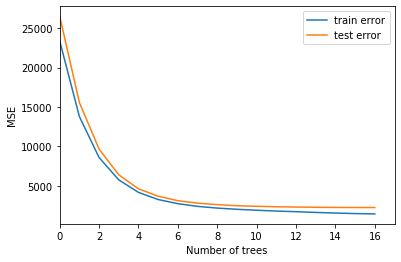

In [13]:
error_of_n_trees_plot(len(test_mse), train_mse, test_mse)

***При небольших числах деревьев ошибка заметно падает с ростом числа деревьев в ансамбле, однако затем выходит практически на постоянный уровень, т.е. добавление деревьев в ансамбль становится нецелесообразным, т.к. время обучения растет.*** 

### *от максимальной глубины деревьев*

In [14]:
%%time
n_trees = 4
coefs = [1] * n_trees
eta = 0.1

max_depth_ = np.arange(1, 26)
train_mse = []
test_mse = []

for max_depth in max_depth_:
    trees = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_mse.append(train_err)
    test_mse.append(test_err)

Wall time: 10.7 s


In [15]:
def error_of_n_trees_plot(max_depth, train_errors, test_errors):
    plt.xlabel('Maximum depth of trees')
    plt.ylabel('MSE')
    plt.xlim(0, max_depth)
    plt.plot(list(range(max_depth)), train_errors, label='train error')
    plt.plot(list(range(max_depth)), test_errors, label='test error')
    plt.legend(loc='upper right')
    plt.show()

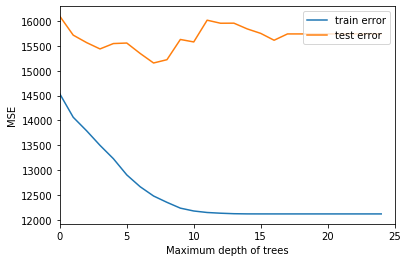

In [16]:
error_of_n_trees_plot(max(max_depth_), train_mse, test_mse)

***Незначительная глубина деревьев может приводить к недообучениюмодели, а слишком большая - к переобучению.***

## 2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [17]:
def stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees = []
    train_errors = []
    test_errors = []
    
    np.random.seed(42)
    n_samples = X_train.shape[0]
    n_samples_for_sgb = int(0.5 * n_samples)
    idx = np.arange(n_samples)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        ind = np.random.choice(idx, n_samples_for_sgb)

        if len(trees) == 0:
            tree.fit(X_train[ind], y_train[ind])            
        else:
            target = gb_predict(X_train[ind], trees, coefs, eta)
            tree.fit(X_train[ind], bias(y_train[ind], target))
            
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [18]:
n_trees = 50
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

%time train_errors_gb, test_errors_gb = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[1:]
%time train_errors_sgb, test_errors_sgb =  stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[1:]

Wall time: 58.1 s
Wall time: 48 s


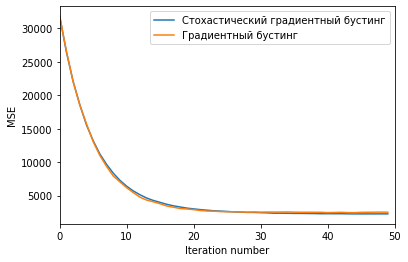

In [19]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors_gb, label='Cтохастический градиентный бустинг')
plt.plot(list(range(n_trees)), test_errors_sgb, label='Градиентный бустинг')
plt.legend(loc='upper right')
plt.show()

***Качество обучения модели стохастическим градиентным бустингом практически идентично полному градиентному бустингу, а время требуется меньше.***